In [1]:
import torch
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is NOT available")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Variable used below to set model training mode to use GPU

GPU is available


real    5180
fake    2820
Name: cv_class, dtype: int64


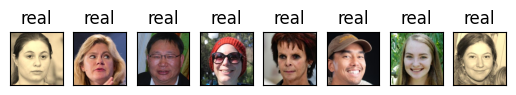

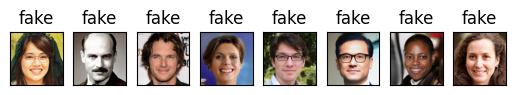

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from glob import glob
import os
import pandas as pd
import numpy as np

DATASET_ROOT = '.'
DATASET_TRAIN_FOLDER = os.path.join(DATASET_ROOT, 'train')
DATASET_TRAIN_CSV = os.path.join(DATASET_ROOT, 'train.csv')

DATASET_TEST_FOLDER = os.path.join(DATASET_ROOT, 'test')
DATASET_TEST_CSV = os.path.join(DATASET_ROOT, 'test.csv')




cv_datatrain = pd.read_csv(DATASET_TRAIN_CSV)


class_counts = cv_datatrain['cv_class'].value_counts()
print(class_counts)
%matplotlib inline

def PrintImageSamples(image_paths, label):
    fig, ax = plt.subplots(1,len(image_paths))
    for i, path in enumerate(image_paths):
        ax[i].title.set_text(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(mpimg.imread(path))

SAMPLES = 8
real_image_paths = cv_datatrain[cv_datatrain['cv_class'] == 'real'][:SAMPLES]['cv_filename']
real_image_paths = [os.path.join(DATASET_TRAIN_FOLDER, p) for p in real_image_paths]
PrintImageSamples(real_image_paths, 'real')

fake_image_paths = cv_datatrain[cv_datatrain['cv_class'] == 'fake'][:SAMPLES]['cv_filename']
fake_image_paths = [os.path.join(DATASET_TRAIN_FOLDER, p) for p in fake_image_paths]
PrintImageSamples(fake_image_paths, 'fake')

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.io import read_image # Load image file path to ndarray

LABELS_MAP = { # Convert text labels to class index, model is trained using class indexes
    'real': 0 ,
    'fake': 1 }
NUM_CLASS = len(LABELS_MAP)

class ImageDatasetFromCSV(Dataset):
    def __init__(self, annotations_csv, root_dir, has_labels, transform=None):
        self.data_frame = pd.read_csv(annotations_csv)
        self.root_dir = root_dir
        self.has_labels = has_labels
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if self.has_labels: # Only training set has labels, set label=None for train=False
            image_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, -2]) # data_frame column 0 are filenames
            image = read_image(image_path) # In pytorch, image Tensor is in C H W dimensions
            if self.transform:
                image = self.transform(image) # Apply image augmentation transformations
            label = self.data_frame.iloc[idx, -1] # Index 1 = class

            label_idx = LABELS_MAP[label] # Convert textual label to a class index
            return {"image": image, "label": label_idx}
        else:
            image_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, -1]) # data_frame column 0 are filenames

            image = read_image(image_path) # In pytorch, image Tensor is in C H W dimensions
            if self.transform:
                image = self.transform(image) # Apply image augmentation transformations
            return {"image": image}


In [4]:
# Train set Transforms
# Models usually take in float32 (instead of uint8 [0..255])
TRAIN_IM_W = 244
TRAIN_IM_H = 244 # 299 for inception, 384 for efficientnetv2_s, 244 for most others.
train_transform = transforms.Compose([
        transforms.Resize((TRAIN_IM_W, TRAIN_IM_H)),
        transforms.RandomHorizontalFlip(),
        transforms.ConvertImageDtype(dtype=torch.float32)])

# Test set Transforms
TEST_IM_W = 244
TEST_IM_H = 244
test_transform = transforms.Compose([
        transforms.Resize((TEST_IM_W, TEST_IM_H)),
        transforms.ConvertImageDtype(dtype=torch.float32)])

In [5]:
# Portion out some train images for validation
TRAIN_VALID_SPLIT = [0.8, 0.2] # Ratio of train/validation split

labelled_dataset = ImageDatasetFromCSV(annotations_csv=DATASET_TRAIN_CSV, root_dir=DATASET_TRAIN_FOLDER, has_labels=True, transform=train_transform)
train_dataset, valid_dataset = random_split(labelled_dataset, TRAIN_VALID_SPLIT)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Create dataset from testing unlabelled data. Set has_labels = False since no label in csv.
test_dataset = ImageDatasetFromCSV(annotations_csv=DATASET_TEST_CSV, root_dir=DATASET_TEST_FOLDER, has_labels=False, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Dataset statistics
print(f"Total Samples - Train:{len(train_dataset)}, Val:{len(valid_dataset)}, Test:{len(test_dataset)}")

Total Samples - Train:6400, Val:1600, Test:2000


Images batch shape: torch.Size([32, 3, 244, 244])
Labels batch shape: torch.Size([32])
Label Index: 0, Label Class: real


C:\Users\asyra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


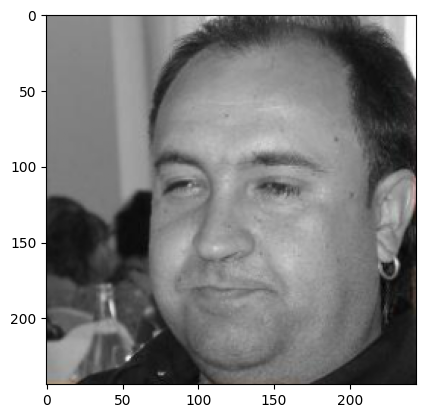

In [6]:
# Train dataloader
extracted_batch = next(iter(train_dataloader)) # Get first batch
print(f"Images batch shape: {extracted_batch['image'].size()}")
print(f"Labels batch shape: {extracted_batch['label'].size()}")
extracted_image = extracted_batch['image'][0].squeeze() # Take 1 image to visualize
extracted_label_idx = extracted_batch['label'][0] # Take corresponding label index of image
label = list(LABELS_MAP.keys())[list(LABELS_MAP.values()).index(extracted_label_idx)] # Convert label index back to text
print(f"Label Index: {extracted_label_idx}, Label Class: {label}")

# rcParams['figure.figsize'] = 4,4 # Change display figure size
plt.imshow(np.transpose(extracted_image, (1, 2, 0))) # Convert pytorch C H W to numpy image H W C format
plt.show()

Images batch shape: torch.Size([1, 3, 244, 244])


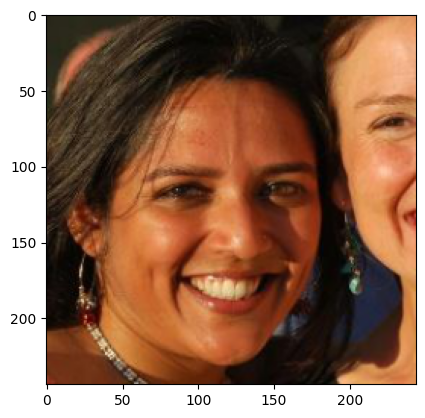

In [7]:
# Test dataloader
extracted_test_batch = next(iter(test_dataloader))
print(f"Images batch shape: {extracted_test_batch['image'].size()}")
extracted_image = extracted_test_batch['image'][0].squeeze()
plt.imshow(np.transpose(extracted_image, (1, 2, 0)))
plt.show()

In [8]:
from torch.nn import Linear
from torchvision.models import resnet50, ResNet50_Weights

### Change your model here, or define your custom model
def MyModel():
    pre_trained = ResNet50_Weights.DEFAULT # Choose to use pre-trained weights or not (train from scratch)
    model = resnet50(weights=pre_trained)
    model.fc = Linear(in_features=2048, out_features = NUM_CLASS) # Change out last fully connected layer to match number of classes in dataset
    return model

model = MyModel()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, Adadelta, RMSprop # Optimizers

criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(),lr=0.001, momentum=0.9) # Configure learning rate parameters as needed

In [10]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=3, min_delta=0)

In [11]:
from tqdm import tqdm
from time import sleep


def train(model, train_dataloader, valid_dataloader, optimizer, criterion,
          num_epochs, device, save_model_path, early_stopper=None):
    model.train() # Set pytorch model to train mode
    model.to(device) # Set pytorch model to run in GPU or CPU mode

    for epoch in range(num_epochs):

        # Train
        running_train_loss = 0.0
        train_epoch = tqdm(train_dataloader) # tqdm = Progress bar
        for batch_idx, batch in enumerate(train_epoch):
            # Get batch of images & labels from Dataloader
            images = batch['image']
            labels = batch['label']
            images = images.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_train_loss += loss.item()
            train_avg_loss = running_train_loss/(batch_idx+1)
            train_epoch.set_description(f"Epoch {epoch}, Train loss: {train_avg_loss:.5f}")

        # Validation
        running_valid_loss = 0.0
        valid_epoch = tqdm(valid_dataloader)
        optimizer.zero_grad()
        for batch_idx, batch in enumerate(valid_epoch):
            images = batch['image']
            labels = batch['label']
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()
            valid_avg_loss = running_valid_loss/(batch_idx+1)
            valid_epoch.set_description(f"Epoch {epoch}, Valid loss: {valid_avg_loss:.5f}")

        print(f"Summary: Epoch {epoch} - Train loss: {train_avg_loss:.5f}, Valid loss: {valid_avg_loss:.5f}")

        # Save Model Checkpoint. See https://pytorch.org/tutorials/beginner/saving_loading_models.html#save
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_avg_loss,
            }, save_model_path)

        # Early Stopping
        if early_stopper is not None:
            if early_stopper.early_stop(valid_avg_loss):
                print(f"Early Stopping: No improvement for last {early_stopper.patience} epochs, stopping training")
                break


In [12]:
EPOCH = 3
SAVE_MODEL_PATH = 'model.pt'
train(model, train_dataloader, valid_dataloader, optimizer, criterion, EPOCH, DEVICE, SAVE_MODEL_PATH, early_stopper)

Epoch 0, Valid loss: 0.32853: 100%|██████████| 50/50 [33:05<00:00, 39.71s/it]   


Summary: Epoch 0 - Train loss: 0.49110, Valid loss: 0.32853


Epoch 1, Valid loss: 0.17072: 100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


Summary: Epoch 1 - Train loss: 0.21838, Valid loss: 0.17072


Epoch 2, Valid loss: 0.11912: 100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


Summary: Epoch 2 - Train loss: 0.11191, Valid loss: 0.11912


In [13]:
def evaluate(model, test_dataloader, device):
    with torch.no_grad(): # https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/2
        model.eval() # Affects batch normalization and dropout layers (they work differently in training vs evaluation mode)
        model.to(device)
        predictions = []
        test_set = tqdm(test_dataloader)
        for batch_idx, batch in enumerate(test_set):
            images = batch['image']
            images = images.to(device)
            prediction = model(images)
            # If SoftmaxCrossEntopy loss was used, output is logits, convert to probability scores
            prediction = torch.nn.functional.softmax(prediction, dim=1)
            predictions.extend(prediction.tolist())
        return predictions

predictions = evaluate(model, test_dataloader, DEVICE)
print(predictions)

100%|██████████| 2000/2000 [00:28<00:00, 69.36it/s]

[[0.9884422421455383, 0.011557712219655514], [0.17477092146873474, 0.8252291083335876], [0.8180450797080994, 0.18195492029190063], [0.9994426369667053, 0.0005573772941716015], [0.008864637464284897, 0.9911353588104248], [0.8869171738624573, 0.1130828782916069], [0.038489557802677155, 0.961510419845581], [0.8168494701385498, 0.1831505000591278], [0.2648044526576996, 0.7351955771446228], [0.5212177038192749, 0.4787822961807251], [0.001800771802663803, 0.9981992840766907], [0.9945383667945862, 0.005461631342768669], [0.9998770952224731, 0.00012294042971916497], [0.007884646765887737, 0.992115318775177], [0.007087859325110912, 0.9929121136665344], [0.9991693496704102, 0.0008307240204885602], [0.009276201017200947, 0.9907237887382507], [0.9993340373039246, 0.0006659110076725483], [0.0019330158829689026, 0.9980669617652893], [0.026967190206050873, 0.9730327725410461], [0.9925388693809509, 0.007461112923920155], [0.0034347970504313707, 0.9965652823448181], [0.015819741412997246, 0.98418021202

In [14]:
# if output of model was 2 class ( multi-class ) probability scores, take the first value to convert to prediction scores for binary class
predictions = [x[1] for x in predictions]
print(predictions)

[0.011557712219655514, 0.8252291083335876, 0.18195492029190063, 0.0005573772941716015, 0.9911353588104248, 0.1130828782916069, 0.961510419845581, 0.1831505000591278, 0.7351955771446228, 0.4787822961807251, 0.9981992840766907, 0.005461631342768669, 0.00012294042971916497, 0.992115318775177, 0.9929121136665344, 0.0008307240204885602, 0.9907237887382507, 0.0006659110076725483, 0.9980669617652893, 0.9730327725410461, 0.007461112923920155, 0.9965652823448181, 0.984180212020874, 0.9854112863540649, 0.0006091403192840517, 0.004284976050257683, 0.001953545957803726, 0.053280577063560486, 0.0012983522610738873, 7.166830619098619e-05, 0.9915506839752197, 0.10983263701200485, 0.01627339981496334, 0.004155342001467943, 0.7578539848327637, 0.9860138893127441, 0.9702994227409363, 0.004055631812661886, 0.0016591016901656985, 3.365127486176789e-05, 0.03501296788454056, 0.0016859647585079074, 0.0011715155560523272, 0.019772984087467194, 0.0008299924666061997, 0.0007143563707359135, 0.998715877532959, 0

In [22]:
# Write to csv predictions
test_df = pd.read_csv(DATASET_TEST_CSV)
classifications = []
for value in predictions:
    if value < 0.5:
        classifications.append("real")
    else:
        classifications.append("fake")
test_df['class'] = classifications

test_df.to_csv('predictions.csv', index=False)
print(test_df['class'])

0       real
1       fake
2       real
3       real
4       fake
        ... 
1995    real
1996    fake
1997    fake
1998    fake
1999    real
Name: class, Length: 2000, dtype: object
